# What's in this notebook?
This notebook is for cleaning and merging yield curve, PPI, and Real GDP data
So far all the data here is from:  https://fred.stlouisfed.org/ 
In our models the start of a recession occurs when Real GDP falls for 2 consecutive quarters,
and the end of recession when GDP rises for 2 consecutive quarters.
Exponential smoothing is done on yield curve and PPI data to make modeling easier, and to enable velocity and acceleration features to be added.
Exponential smoothing assumes quarterly seasonallity, and this is reflected in seasonal period choices based on timescales of the different datasets.


In [91]:
# imports
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np

C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\3648798466.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['T10Y2Y'] = yc_clean['T10Y2Y'].astype(float) # convert to float after cleaning.
C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\3648798466.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['DATE'] = pd.to_datetime(yc_clean['DATE'], format='%Y-%m-%d')


,DATE,GDPC1
118,1976-07-01,5969.089
119,1976-10-01,6012.356
120,1977-01-01,6083.391
121,1977-04-01,6201.659
122,1977-07-01,6313.559


,DATE,T10Y2Y
0,1976-06-01,0.68
1,1976-06-02,0.71
2,1976-06-03,0.70
3,1976-06-04,0.77
4,1976-06-07,0.79


,DATE,WPSID62
350,1976-06-01,65.2
351,1976-07-01,64.8
352,1976-08-01,63.6
353,1976-09-01,63.4
354,1976-10-01,63.0


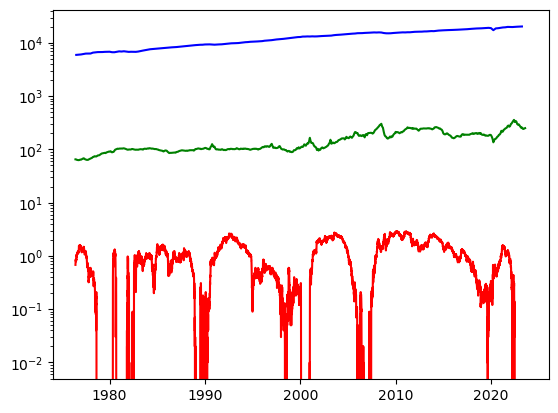

In [92]:
# Read in the data sets
gdp = pd.read_csv(r"C:\Users\Edmund\OMSA\MGT6203\group project\Team36_group_project\Data\Real_GDP_GDPC1.csv")
yc = pd.read_csv(r"C:\Users\Edmund\OMSA\MGT6203\group project\Team36_group_project\Data\yield_curve_T10Y2Y.csv")
# Using only seasonally adjusted PPI data.
PPI = pd.read_csv(r"C:\Users\Edmund\OMSA\MGT6203\group project\Team36_group_project\Data\PPI_Commodity_Intermediate_Demand_Unprocessed_Goods_seasonally_adjusted.csv")

yc_clean = yc[yc['T10Y2Y'] != '.'] # remove placeholders in yield curve data.
yc_clean['T10Y2Y'] = yc_clean['T10Y2Y'].astype(float) # convert to float after cleaning.
# Convert 'DATE' columns to datetime type
gdp['DATE'] = pd.to_datetime(gdp['DATE'], format='%Y-%m-%d')
PPI['DATE'] = pd.to_datetime(PPI['DATE'], format='%Y-%m-%d')
yc_clean['DATE'] = pd.to_datetime(yc_clean['DATE'], format='%Y-%m-%d')
# get subset of PPI and GDP in the same date range as yield curve
gdp_76_plus = gdp[gdp['DATE'] >= yc_clean['DATE'].loc[0]]
PPI_76_plus = PPI[PPI['DATE'] >= yc_clean['DATE'].loc[0]]
display(gdp_76_plus.head(5))
display(yc_clean.head(5))
display(PPI_76_plus.head(5))

# plot everything in log scale:
plt.plot(gdp_76_plus['DATE'], gdp_76_plus['GDPC1'], color = 'blue')
plt.plot(PPI_76_plus['DATE'], PPI_76_plus['WPSID62'], color = 'green')
plt.plot(yc_clean['DATE'], yc_clean['T10Y2Y'], color = 'red')
plt.yscale('log')
plt.show()


C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\96950484.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['T10Y2Y trend'] = yc_ts.trend


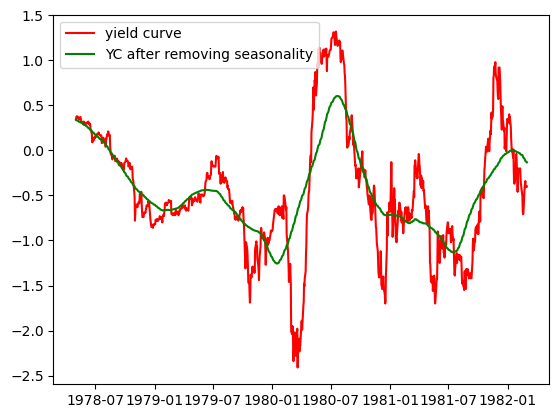

C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\96950484.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['T10Y2Y velocity'] = np.gradient(yc_clean['T10Y2Y trend'])
C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\96950484.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  yc_clean['T10Y2Y acceleration'] = np.gradient(yc_clean['T10Y2Y velocity'])


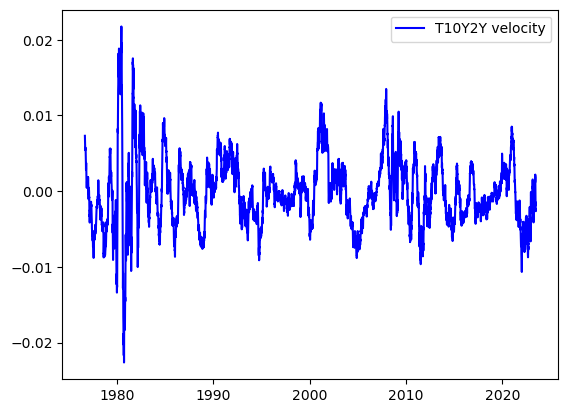

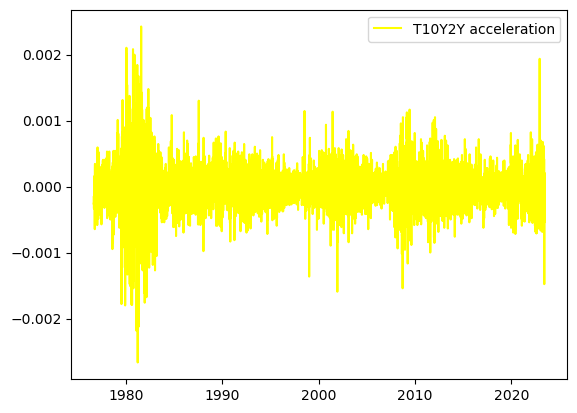

In [93]:
import statsmodels.tsa.api as tsa # Use this for exponential smoothing.

# Assume each point is a day for yc, and there is quarterly seasonality
yc_ts = tsa.seasonal_decompose(yc_clean['T10Y2Y'], model='additive', filt=None, period=120, two_sided=True, extrapolate_trend=0)
yc_clean['T10Y2Y trend'] = yc_ts.trend

plt.plot(yc_clean['DATE'].loc[500:1500], yc_clean['T10Y2Y'].loc[500:1500], color = 'red', label = "yield curve")
plt.plot(yc_clean['DATE'].loc[500:1500], yc_clean['T10Y2Y trend'].loc[500:1500], color = 'green', label = "YC after removing seasonality")
plt.legend()
plt.show()

# now let's generate velocity and acceleration features based on the exponentially smoothed data:

yc_clean['T10Y2Y velocity'] = np.gradient(yc_clean['T10Y2Y trend'])
yc_clean['T10Y2Y acceleration'] = np.gradient(yc_clean['T10Y2Y velocity'])

plt.plot(yc_clean['DATE'], yc_clean['T10Y2Y velocity'], color = 'blue', label = 'T10Y2Y velocity')
plt.legend()
plt.show()

plt.plot(yc_clean['DATE'], yc_clean['T10Y2Y acceleration'], color = 'yellow', label = 'T10Y2Y acceleration')
plt.legend()
plt.show()



In [94]:
# # What does the yc velocity look like?
# yc_clean['velocity'] = np.gradient(yc_clean['T10Y2Y'])

# plt.plot(yc_clean['DATE'], yc_clean['velocity'], color = 'red')
# plt.yscale('linear')
# plt.show()

C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\1397554436.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PPI_76_plus['WPSID62 trend'] = PPI_ts.trend


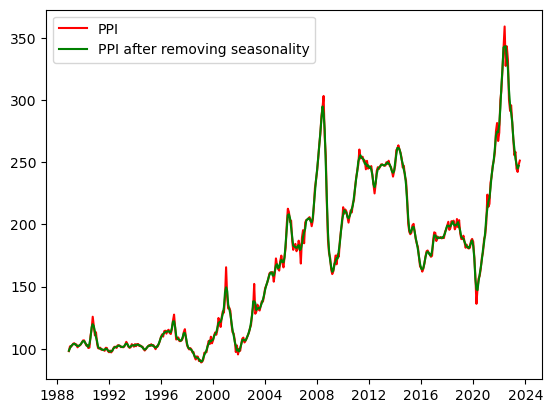

C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\1397554436.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PPI_76_plus['WPSID62 velocity'] = np.gradient(PPI_76_plus['WPSID62'])
C:\Users\Edmund\AppData\Local\Temp\ipykernel_8268\1397554436.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  PPI_76_plus['WPSID62 acceleration'] = np.gradient(PPI_76_plus['WPSID62 velocity'])


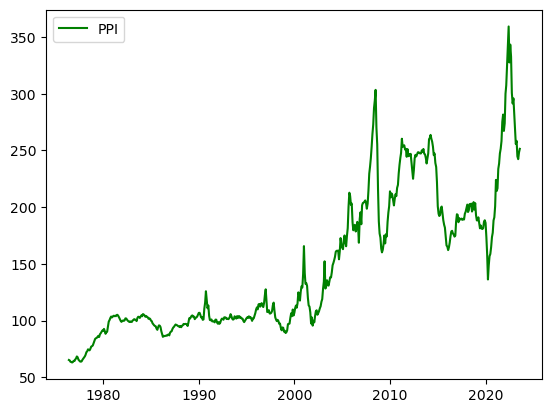

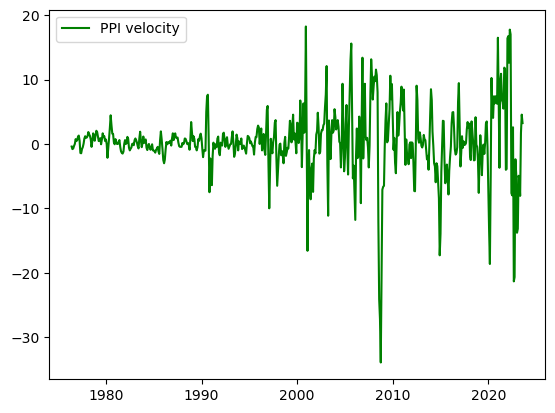

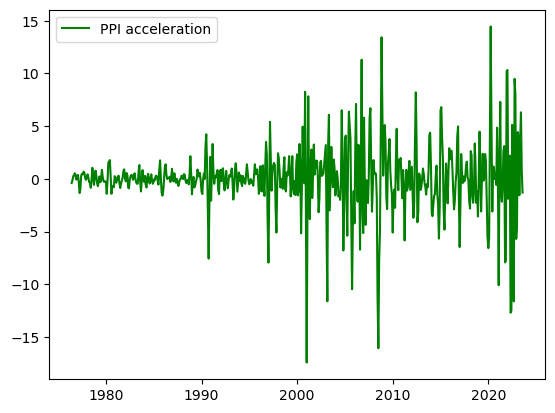

In [95]:
# Get velocity and acceleration for PPI
# assume monthly data and quarterly seasonality
PPI_ts = tsa.seasonal_decompose(PPI_76_plus['WPSID62'], model='additive', filt=None, period=3, two_sided=True, extrapolate_trend=0)
PPI_76_plus['WPSID62 trend'] = PPI_ts.trend

plt.plot(PPI_76_plus['DATE'].loc[500:1500], PPI_76_plus['WPSID62'].loc[500:1500], color = 'red', label = 'PPI')
plt.plot(PPI_76_plus['DATE'].loc[500:1500], PPI_76_plus['WPSID62 trend'].loc[500:1500], color = 'green', label = 'PPI after removing seasonality')
plt.legend()
plt.show()

PPI_76_plus['WPSID62 velocity'] = np.gradient(PPI_76_plus['WPSID62'])
PPI_76_plus['WPSID62 acceleration'] = np.gradient(PPI_76_plus['WPSID62 velocity'])

plt.plot(PPI_76_plus['DATE'], PPI_76_plus['WPSID62'], color = 'green', label = 'PPI')
plt.legend()
plt.show()
plt.plot(PPI_76_plus['DATE'], PPI_76_plus['WPSID62 velocity'], color = 'green', label = 'PPI velocity')
plt.legend()
plt.show()
plt.plot(PPI_76_plus['DATE'], PPI_76_plus['WPSID62 acceleration'], color = 'green', label = 'PPI acceleration')
plt.legend()
plt.show()

In [96]:
# Data is all here. Now I need to merge the dataframes. 
# Merge GDP with yield curve:
merged_df = gdp_76_plus.merge(PPI_76_plus, on = 'DATE', how = 'outer')
# Merge the result with PPI:
merged_df = merged_df.merge(yc_clean, on = 'DATE', how = 'outer')
# now sort by date ascending:
merged_df = merged_df.sort_values(by=['DATE'], ascending = True)
display(merged_df.head(30))
merged_df.shape
# I need to talk to the group about what timescale we want to use. For now I will just interpolate the data.


,DATE,GDPC1,WPSID62,WPSID62 trend,WPSID62 velocity,WPSID62 acceleration,T10Y2Y,T10Y2Y trend,T10Y2Y velocity,T10Y2Y acceleration
188,1976-06-01,NaN,65.2,NaN,-0.4,-0.40,0.68,NaN,NaN,NaN
567,1976-06-02,NaN,NaN,NaN,NaN,NaN,0.71,NaN,NaN,NaN
568,1976-06-03,NaN,NaN,NaN,NaN,NaN,0.70,NaN,NaN,NaN
569,1976-06-04,NaN,NaN,NaN,NaN,NaN,0.77,NaN,NaN,NaN
570,1976-06-07,NaN,NaN,NaN,NaN,NaN,0.79,NaN,NaN,NaN
571,1976-06-08,NaN,NaN,NaN,NaN,NaN,0.79,NaN,NaN,NaN
572,1976-06-09,NaN,NaN,NaN,NaN,NaN,0.82,NaN,NaN,NaN
573,1976-06-10,NaN,NaN,NaN,NaN,NaN,0.86,NaN,NaN,NaN
574,1976-06-11,NaN,NaN,NaN,NaN,NaN,0.83,NaN,NaN,NaN
575,1976-06-14,NaN,NaN,NaN,NaN,NaN,0.83,NaN,NaN,NaN


(12024, 10)

In [97]:
# Export to csv then merge with other dataframes that the team comes up with.
from datetime import datetime
now = datetime.now()
date_str = str(now.year) + str(now.month) + str(now.day) + str(now.hour) + str(now.minute) + str(now.second)
print(date_str)
output_dir = r"C:\\Users\\Edmund\\OMSA\\MGT6203\\group project\Team36_group_project\Data\\"
output_fname = output_dir + "GDP_PPI_YC_"  + date_str + '.csv'
merged_df.to_csv(output_fname, index=False)

2023925212433
